# Training Notebook
This notebook loads the labelled wavefroms from SystemLink Server and trains a simple neural network, and uploads the model to SystemLink Server

### Importing SystemLink Python Modules

In [1]:
from systemlink.fileingestionclient import FileIngestionClient, messages as fileingestion_messages
from systemlink.tdmsreaderclient import TDMSReaderClient, messages as tdmsreader_messages

### Importing Some Machine Learning Libraries

In [2]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns
import numpy as np
import pandas as pd

import time
import h5py

Using TensorFlow backend.


### Choose the Dataset

In [3]:
shiftId = "shift_0041"
wavefrom_length = 152
train_split = 0.8


labels = ['anomalous', 'normal']
label_to_id = {'anomalous':0, 'normal':1}

### Fetching File Ids from SystemLink

In [4]:
fileingestionclient = FileIngestionClient(service_name='FileIngestionClient')
tdmsreaderclient = TDMSReaderClient(service_name='TDMSReaderClient')

equal_op = fileingestion_messages.QueryOperator(fileingestion_messages.QueryOperator.EQUAL)
query_shift_id = fileingestion_messages.StringQueryEntry('shiftId', shiftId, equal_op)

file_ids = {label:[] for label in labels}
no_of_classes = len(labels)

for label in labels:
    query_label = fileingestion_messages.StringQueryEntry('manualLabel', label, equal_op)
    res = fileingestionclient.query_files(properties_query=[query_shift_id, query_label])
    num_files = len(res.available_files)

    if num_files == 0:
        raise RuntimeError('No files with label %s found'%label)

    else:
        file_ids[label].extend([file.id for file in res.available_files])


### Loading Data from SystemLink and Splitting into train and validation splits

In [5]:
no_of_train_examples = 0
no_of_validation_examples = 0

for label in labels:
    no_of_train_examples_in_label = int(len(file_ids[label]) * train_split)
    no_of_validation_examples_in_label = len(file_ids[label]) - no_of_train_examples_in_label
    
    no_of_train_examples += no_of_train_examples_in_label
    no_of_validation_examples += no_of_validation_examples_in_label
    
X_train = np.ndarray([no_of_train_examples, wavefrom_length])
Y_train = np.zeros([no_of_train_examples])

X_validation = np.ndarray([no_of_validation_examples, wavefrom_length])
Y_validation = np.zeros([no_of_validation_examples])

train_file_ids = []
validation_file_ids = []
train_idx = 0
validation_idx = 0
group_name = "sensor_data"

for label in labels:
    for idx,file_id in enumerate(file_ids[label]):
        
        limits = tdmsreader_messages.SkipTakeReturnCount(0, -1, True)
        channels = tdmsreaderclient.get_channels(file_id, group_name, limits)
        
        sensor_waveforms = []
        for channel_name in channels.names:
            channel_specifier = tdmsreader_messages.OneChannelSpecifier(
            file_id_=file_id,
            group_name_=group_name,
            channel_name_=channel_name)
        
            data_window = tdmsreader_messages.DataWindow(
                xmin_=0,
                xmax_=1000,
                xlog_=False,
                ymin_=0,
                ymax_=1000,
                ylog_=False,
                decimatex_=0,
                decimatey_=0,
                show_points_=False,
                show_lines_=False)
            xy_channels = tdmsreader_messages.XYChannels(
                xchannel_=None,
                ychannels_=[channel_specifier],
                data_window_=data_window)
            channel_spec = tdmsreader_messages.ChannelSpecifications(xy_channels_=[xy_channels])
            sensor_waveform = tdmsreaderclient.query_data(channel_spec)
            sensor_waveforms.append(np.array(sensor_waveform.data[0].y[0].numeric_data))
            
            
        if idx < int(len(file_ids[label]) * train_split):  # train_split = 0.8 
            X_train[train_idx,:] = sensor_waveforms[0]
            Y_train[train_idx] = label_to_id[label]
            train_file_ids.append(file_id)
            train_idx +=1
            
        else:
            X_validation[validation_idx,:] = sensor_waveforms[0]
            Y_validation[validation_idx] = label_to_id[label]
            validation_file_ids.append(file_id)
            validation_idx +=1                
                
X_validation, Y_validation, validation_file_ids = shuffle(X_validation, Y_validation, validation_file_ids, random_state=4153)
X_train, Y_train, train_file_ids = shuffle(X_train, Y_train, train_file_ids, random_state=153)

X_train_reshape = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation_reshape = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
Y_train_cat = to_categorical(Y_train)
Y_validation_cat = to_categorical(Y_validation)

display(Markdown('<h1>Total Labelled Waveforms : %s</h1><br>'%(X_train.shape[0]+X_validation.shape[0])))

display(Markdown('<h2>Train Waveforms : %s</h2>'%(Y_train.shape[0])))
display(Markdown('<h4>Normal: %s</h4>'%(Y_train[Y_train == 1].shape[0])))
display(Markdown('<h4>Anomalous : %s</h4><br>'%(Y_train[Y_train == 0].shape[0])))

display(Markdown('<h2>Validation Waveforms : %s</h2>'%(Y_validation.shape[0])))
display(Markdown('<h4>Normal : %s</h4>'%(Y_validation[Y_validation == 1].shape[0])))
display(Markdown('<h4>Anomalous : %s</h4><hr>'%(Y_validation[Y_validation == 0].shape[0])))


<h1>Total Labelled Waveforms : 1000</h1><br>

<h2>Train Waveforms : 799</h2>

<h4>Normal: 722</h4>

<h4>Anomalous : 77</h4><br>

<h2>Validation Waveforms : 201</h2>

<h4>Normal : 181</h4>

<h4>Anomalous : 20</h4><hr>

### Visualizing some of the raw data examples

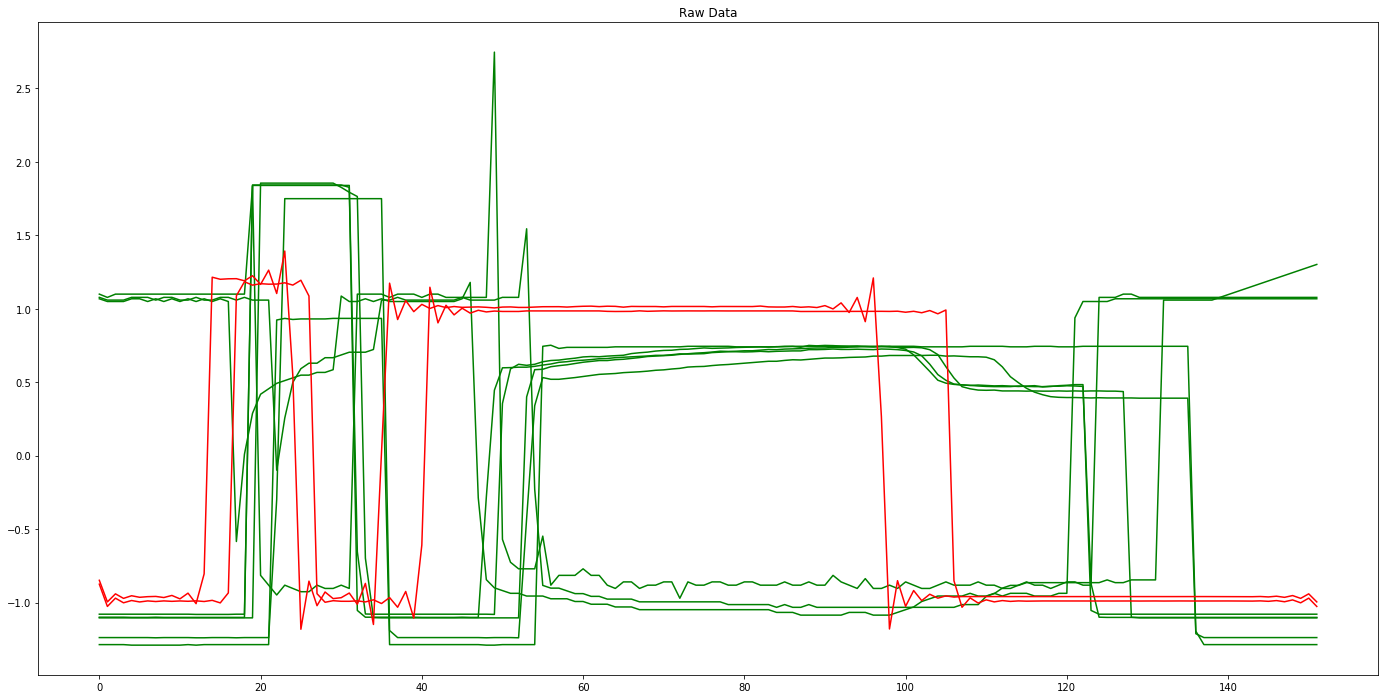

In [6]:
plt.figure(figsize = (24,12))
plt.title("Raw Data")
for idx,label in enumerate(Y_train[:10]):
    if label == 1:
        plt.plot(X_train[idx], color='green')
        
for idx,label in enumerate(Y_train[:10]):
    if label == 0:
        plt.plot(X_train[idx], color='red')
plt.show()

### Preprocess the data

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))

X_train_s = []
for x_ in X_train_reshape:
    scaler = scaler.fit(x_)
    X_train_s.append(scaler.transform(x_))
X_train_s = np.array(X_train_s)
train_mean = np.mean(X_train_s, axis=0)
X_train_s_mean = X_train_s - train_mean

X_validation_s = []
for x_ in X_validation_reshape:
    scaler = scaler.fit(x_)
    X_validation_s.append(scaler.transform(x_))
X_validation_s = np.array(X_validation_s)
X_validation_s_mean = X_validation_s - train_mean
class_weights = compute_class_weight('balanced', np.unique(Y_train), Y_train)

### Defining a simple model architecture

In [11]:
def simple_model(input_shape): 
    
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(nb_classes, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),   
            metrics=['accuracy'])  
    
    return model


### Training the Model

In [12]:
input_shape = X_train_s[0,:,0].shape
nb_classes = 2
model = simple_model(input_shape)
model_name = "simple_model"
model_version = "001"
model_filepath = "models/{}_v{}.h5".format( model_name, model_version)
print(model_filepath)

hist = model.fit(X_train_s_mean[:,:,0], Y_train_cat, epochs=12, batch_size=64,
                 validation_split = 0.2,class_weight=class_weights)

models/simple_model_v001.h5
Instructions for updating:
Use tf.cast instead.
Train on 639 samples, validate on 160 samples
Epoch 1/12
639/639 [==============================] - 1s 911us/step - loss: 0.7697 - acc: 0.5837 - val_loss: 0.5602 - val_acc: 0.7625
Epoch 2/12
639/639 [==============================] - 0s 72us/step - loss: 0.4767 - acc: 0.8560 - val_loss: 0.3826 - val_acc: 0.9000
Epoch 3/12
639/639 [==============================] - 0s 227us/step - loss: 0.3503 - acc: 0.9311 - val_loss: 0.2812 - val_acc: 0.9500
Epoch 4/12
639/639 [==============================] - 0s 103us/step - loss: 0.2666 - acc: 0.9577 - val_loss: 0.2327 - val_acc: 0.9563
Epoch 5/12
639/639 [==============================] - 0s 124us/step - loss: 0.2226 - acc: 0.9499 - val_loss: 0.1818 - val_acc: 0.9500
Epoch 6/12
639/639 [==============================] - 0s 171us/step - loss: 0.1776 - acc: 0.9562 - val_loss: 0.1747 - val_acc: 0.9500
Epoch 7/12
639/639 [==============================] - 0s 189us/step - loss:

### Validating the model performance

In [14]:
preds_prob = model.predict(X_validation_s_mean[:,:,0], verbose=1, batch_size=128)
preds = np.argmax(preds_prob, axis=1)

201/201 [==============================] - 0s 483us/step


### Results

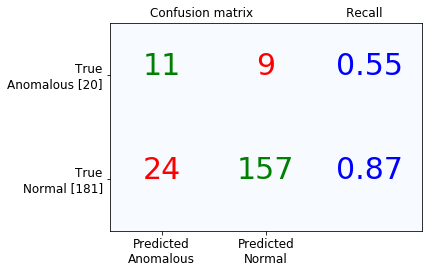

<h1>Validation Accuracy : 83.58 % </h1>

In [15]:
def plot_confusion_matrix_with_recall(cm, classes, normalize=False, title='Confusion matrix                        \
Recall', cmap=plt.cm.Blues):
    plt.figure()
    mat = np.zeros([2,3])
    ax = plt.imshow(mat,  cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["Predicted\n"+class_ for class_ in classes[::-1]], rotation=0, fontsize=12)
    plt.yticks(tick_marks,  ["True\n"+class_+" [%s]"%(cm[idx, 0]+cm[idx, 1]) for idx,class_ in enumerate(classes[::-1])], fontsize=12)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="green" if i==j else "red", fontsize=30)
            
    i=2
    for j in range(2):
        plt.text(i,j, "%0.2f"%(cm[j][j]/(sum(cm[j]))), horizontalalignment="center",color="blue", fontsize=30)

    plt.tight_layout()
    
    plt.show()
    
    
auc_score = roc_auc_score(Y_validation_cat, preds_prob)
validation_acc = int(accuracy_score(Y_validation, preds) * 10000) / 100

cnf_matrix = confusion_matrix(Y_validation, preds)
plot_confusion_matrix_with_recall(cnf_matrix, classes=['Normal','Anomalous'])
display(Markdown('<h1>Validation Accuracy : %s %% </h1>'%(validation_acc)))

### Storing the model and meta data in the SystemLink Server

In [16]:
model.save(model_filepath)  
train_mean_filepath ="models/{}_v{}_train_mean.npy".format(model_name, model_version)
np.save(train_mean_filepath, train_mean)

fileingestionclient.upload_file(model_filepath)
fileingestionclient.upload_file(train_mean_filepath)

'5ce258eecf08272154624901'